In [16]:
%config IPCompleter.greedy=True

In [17]:
import sys
sys.path.append("../..") # relative path to module toolkit

In [18]:
from keras.applications import VGG16
from keras.layers import Dense, GlobalAveragePooling2D, Flatten
from keras.models import Model, Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from toolkit import getLabelsFromDir, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight 
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
# setup
batch_size = 3
train_dir = "../../../images/images_genus/train/"
val_dir = "../../../images/images_genus/val/"
train_images = 12263
val_images = 3381
save_model_name = "vgg16pretrained_genus.h5"
save_plot_name = "vgg16pretrained_trainplot_genus.png"
model_name = 'vgg16pretrained_highest_val_acc_genus.h5'

In [20]:
steps_per_epoch = int(train_images/batch_size) + 1
validation_steps = int(val_images/batch_size) + 1

In [21]:
vgg16_model = VGG16(
    include_top=False, 
    weights="imagenet", 
    input_shape=(224, 224, 3) 
)

x = vgg16_model.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
predictions = Dense(44, activation='softmax')(x)

model = Model(input=vgg16_model.input, output=predictions)

for layer in model.layers:
    layer.trainable = True

/home/herri/.local/lib/python3.5/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  del sys.path[0]


In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [23]:
# compile model
model.compile(loss='categorical_crossentropy',
            optimizer='sgd',
            metrics=['accuracy'])


In [24]:
labels = getLabelsFromDir(train_dir)

train_datagen = ImageDataGenerator(rescale=1./255.)
val_datagen = ImageDataGenerator(rescale=1./255.)

In [25]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    color_mode='rgb',
                                                    target_size=(224, 224),
                                                    shuffle=True)
val_generator = val_datagen.flow_from_directory(val_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    color_mode='rgb',
                                                    target_size=(224, 224),
                                                    shuffle=True)

Found 12263 images belonging to 44 classes.
Found 3381 images belonging to 44 classes.


In [26]:
filepath = model_name

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

early_stop = EarlyStopping(monitor='val_acc', mode='max', patience=4)

callbacks = [checkpoint, early_stop]

In [27]:
the_class_weight = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

In [28]:
#Train
history = model.fit_generator(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=500000,
                    callbacks=callbacks,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    class_weight=the_class_weight)

Epoch 1/500000
4088/4088 [==============================] - 609s 149ms/step - loss: 1.8559 - acc: 0.4741 - val_loss: 0.8257 - val_acc: 0.7278

Epoch 00001: val_acc improved from -inf to 0.72784, saving model to vgg16pretrained_highest_val_acc_genus.h5
Epoch 2/500000
4088/4088 [==============================] - 607s 148ms/step - loss: 0.7244 - acc: 0.7645 - val_loss: 0.5292 - val_acc: 0.8295

Epoch 00002: val_acc improved from 0.72784 to 0.82949, saving model to vgg16pretrained_highest_val_acc_genus.h5
Epoch 3/500000
4088/4088 [==============================] - 607s 148ms/step - loss: 0.4021 - acc: 0.8685 - val_loss: 0.3299 - val_acc: 0.8939

Epoch 00003: val_acc improved from 0.82949 to 0.89391, saving model to vgg16pretrained_highest_val_acc_genus.h5
Epoch 4/500000
4088/4088 [==============================] - 607s 148ms/step - loss: 0.2680 - acc: 0.9103 - val_loss: 0.2762 - val_acc: 0.9116

Epoch 00004: val_acc improved from 0.89391 to 0.91164, saving model to vgg16pretrained_highest_

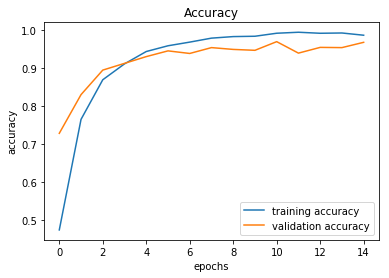

In [29]:
plt.plot(history.history['acc'], label='training accuracy')
plt.plot(history.history['val_acc'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig(save_plot_name, bbox_inches='tight')
plt.show()

In [30]:
#save
model.save(save_model_name)